# TSC implementation | Experiments with Banana and Funnel

## Libraries

In [2]:
!pip install pyro-ppl normflows flowtorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_c

In [3]:
!git clone https://github.com/svsamsonov/Practical_task
!mv Practical_task/* .
!rm -r Practical_task

Cloning into 'Practical_task'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 1), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 69.74 KiB | 23.25 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
import pyro
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.distributions import Normal
from torch.distributions import MultivariateNormal as MNormal
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from typing import Optional, List, Tuple, Iterable, Callable, Union
from torch.distributions import Normal, Categorical
from tqdm.notebook import tqdm, trange
from torch import optim
from torch.nn import KLDivLoss
from pyro.infer import HMC as pyro_hmc
from pyro.infer import MCMC
import normflows as nf
from torch.optim.lr_scheduler import StepLR
from distributions import (
    Distribution,
    IndependentNormal
)

In [5]:
!pip install pot

import jax
import ot
from metrics import ESS, acl_spectrum
from total_variation import (
    average_total_variation,
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 17.0 MB/s eta 0:00:00


In [6]:
os.chdir('/')
if not os.path.exists("/tsc_msc_dl"):
    !git clone https://github.com/katyafilimoshina/tsc_msc_dl

Cloning into 'tsc_msc_dl'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 76 (delta 29), reused 23 (delta 6), pack-reused 0
Receiving objects: 100% (76/76), 3.54 MiB | 10.32 MiB/s, done.
Resolving deltas: 100% (29/29), done.


## Imports from our GitHub

In [7]:
from tsc_msc_dl.distributions import Funnel, Banana
from tsc_msc_dl.samplers import HMC, ISIR, NUTS
from tsc_msc_dl.metrics import compute_metrics
from tsc_msc_dl.plots import visualize_dist_

## ISIR w Banana



### dim=2

In [8]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 2

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [9]:
target = Banana(dim=dim, b=0.02)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [11]:

z_0 = proposal.sample((N_CHAINS, ))
chains, acc_rate  = ISIR(
                  z_0,
                  target,
                  proposal,
                  N_SAMPLES,
                  BURN_IN,
                  n_particles=100,
                  verbose = False,
                )


In [34]:
chains.shape

torch.Size([1000, 1, 2])

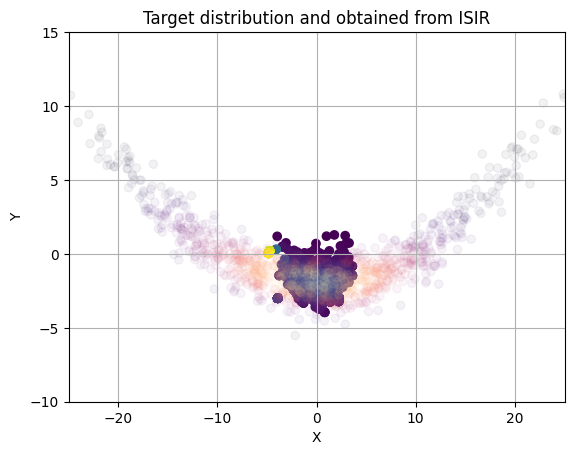

In [35]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from ISIR')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)
ax.set_ylim(-10, 15)
plt.show()

In [36]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.513, Std: 0.014. 
ESS: 0.008 
EMD: 74.917


## dim=10

In [47]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 10

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [48]:
target = Banana(dim=dim, b=0.02)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [49]:
z_0 = proposal.sample((N_CHAINS, ))
chains, acc_rate  = ISIR(
                  z_0,
                  target,
                  proposal,
                  N_SAMPLES,
                  BURN_IN,
                  n_particles=100,
                  verbose = False,
                )


In [50]:
chains.shape

torch.Size([1000, 1, 10])

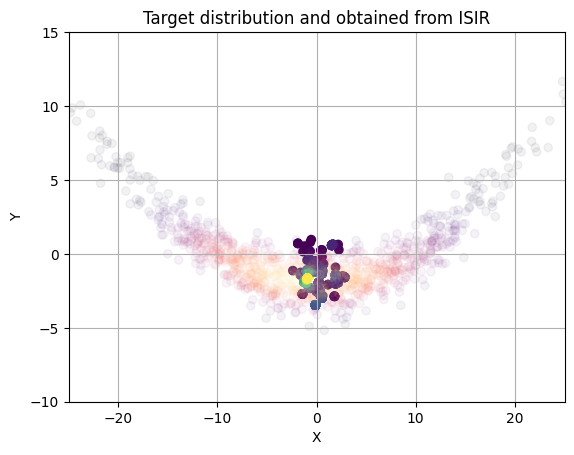

In [51]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from ISIR')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)
ax.set_ylim(-10, 15)
plt.show()

In [52]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.714, Std: 0.006. 
ESS: 0.018 
EMD: 478.532


## dim=50

In [70]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 50

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [71]:
target = Banana(dim=dim, b=0.02)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [72]:
z_0 = proposal.sample((N_CHAINS, ))
chains, acc_rate  = ISIR(
                  z_0,
                  target,
                  proposal,
                  N_SAMPLES,
                  BURN_IN,
                  n_particles=100,
                  verbose = False,
                )


In [73]:
chains.shape

torch.Size([1000, 1, 50])

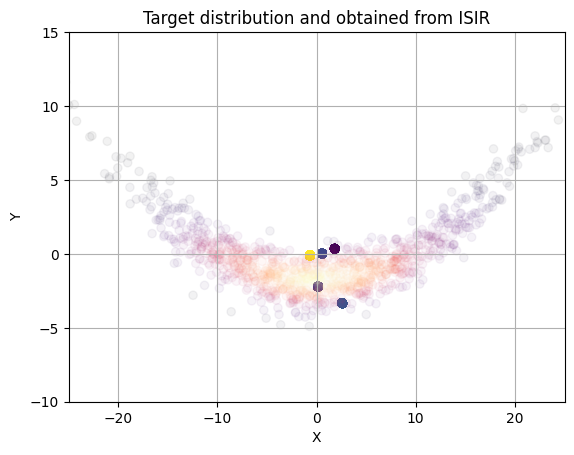

In [74]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from ISIR')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)
ax.set_ylim(-10, 15)
plt.show()

In [75]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.828, Std: 0.008. 
ESS: 0.007 
EMD: 2704.049


## dim=100

In [77]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 100

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [78]:
target = Banana(dim=dim, b=0.02)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [79]:
z_0 = proposal.sample((N_CHAINS, ))
chains, acc_rate  = ISIR(
                  z_0,
                  target,
                  proposal,
                  N_SAMPLES,
                  BURN_IN,
                  n_particles=100,
                  verbose = False,
                )


In [80]:
chains.shape

torch.Size([1000, 1, 100])

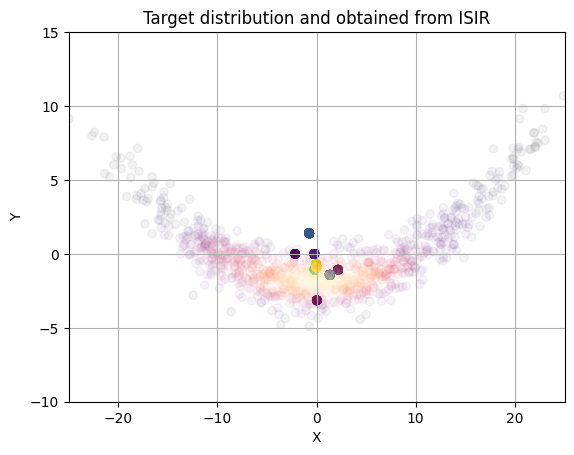

In [81]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from ISIR')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)
ax.set_ylim(-10, 15)
plt.show()

In [82]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.828, Std: 0.006. 
ESS: 0.008 
EMD: 5410.829


## HMC w Banana

## dim=2

In [92]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 2

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [93]:
target = Banana(dim=dim, b=0.02)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [94]:
z_0 = proposal.sample((N_CHAINS, ))
chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size=0.1,
                  num_leapfrog_steps=10,
                  verbose = False,
                )


Sample: 100%|██████████| 1100/1100 [00:01, 701.42it/s, step size=1.01e+00, acc. prob=0.844]


In [95]:
chains.shape

torch.Size([1000, 1, 2])

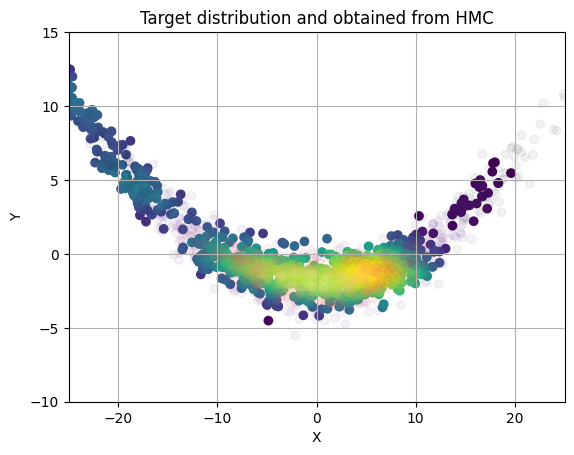

In [96]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from HMC')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)
ax.set_ylim(-10, 15)
plt.show()

In [97]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.157, Std: 0.003. 
ESS: 0.005 
EMD: 30.272


## dim=10

In [104]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 10

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [105]:
target = Banana(dim=dim, b=0.02)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [106]:
z_0 = proposal.sample((N_CHAINS, ))
chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size=0.1,
                  num_leapfrog_steps=10,
                  verbose = False,
                )


Sample: 100%|██████████| 1100/1100 [00:02, 370.48it/s, step size=2.83e-01, acc. prob=0.963]


In [107]:
chains.shape

torch.Size([1000, 1, 10])

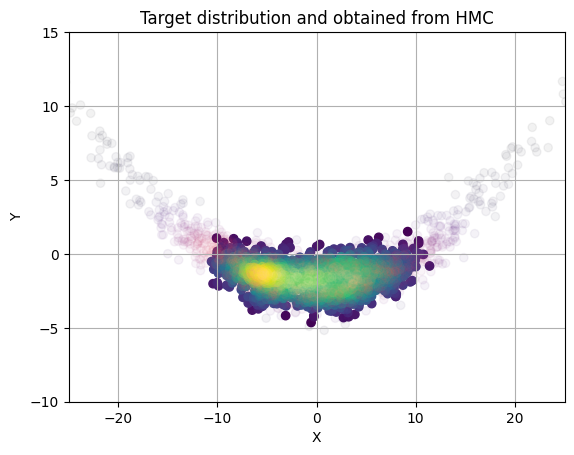

In [108]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from HMC')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)
ax.set_ylim(-10, 15)
plt.show()

In [109]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.157, Std: 0.007. 
ESS: 0.019 
EMD: 235.176


## dim=50

In [12]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 50

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [13]:
target = Banana(dim=dim, b=0.02)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [14]:
z_0 = proposal.sample((N_CHAINS, ))
chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size=0.1,
                  num_leapfrog_steps=10,
                  verbose = False,
                )


Sample: 100%|██████████| 1100/1100 [00:02, 516.36it/s, step size=4.79e-01, acc. prob=0.674]


In [15]:
chains.shape

torch.Size([1000, 1, 50])

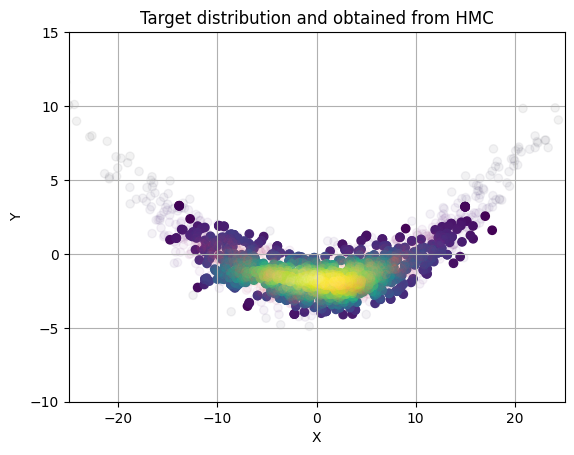

In [16]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from HMC')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)
ax.set_ylim(-10, 15)
plt.show()

In [17]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.214, Std: 0.011. 
ESS: 0.015 
EMD: 3429.484


## dim=100

In [18]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 100

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [19]:
target = Banana(dim=dim, b=0.02)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [20]:
z_0 = proposal.sample((N_CHAINS, ))
chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size=0.1,
                  num_leapfrog_steps=10,
                  verbose = False,
                )


Sample: 100%|██████████| 1100/1100 [00:02, 371.95it/s, step size=3.20e-01, acc. prob=0.858]


In [21]:
chains.shape

torch.Size([1000, 1, 100])

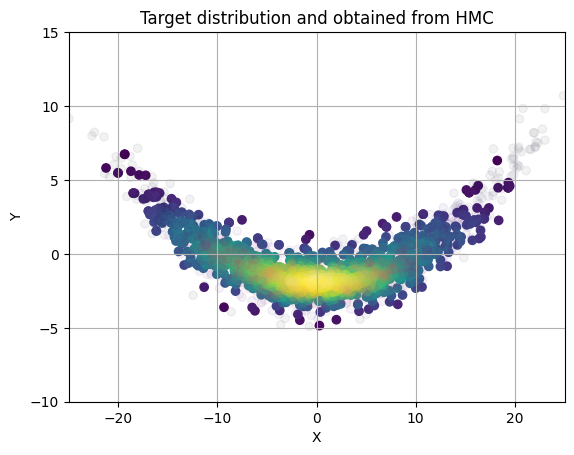

In [22]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from HMC')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist_nf(ax=ax, s=1000, nf = None, alpha=0.05)
ax.set_xlim(-25, 25)
ax.set_ylim(-10, 15)
plt.show()

In [23]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.193, Std: 0.011. 
ESS: 0.017 
EMD: 7630.242


## ISIR w Funnel

## dim=2

In [37]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 2

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [38]:
target =  Funnel(num_dims=dim)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [39]:
z_0 = proposal.sample((N_CHAINS, ))
chains, acc_rate  = ISIR(
                  z_0,
                  target,
                  proposal,
                  N_SAMPLES,
                  BURN_IN,
                  n_particles=100,
                  verbose = False,
                )


In [40]:
chains.shape

torch.Size([1000, 1, 2])

In [41]:
def visualize_dist_nf(target, ax, s=1000, alpha=1.0, nf = None, cmap="magma"):
        points = target.sample(s)
        if nf:
          points = nf(points).detach()
        X = points[:, 0]
        Y = points[:, 1]


        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)


        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        ax.scatter(X, Y, c=Z, label=Z, alpha=alpha, cmap=cmap)

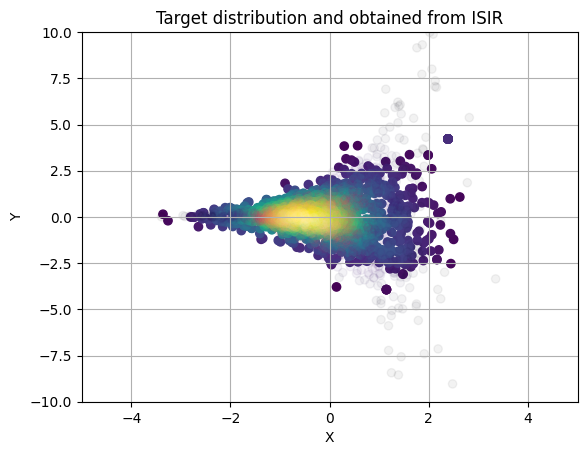

In [42]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from ISIR')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)
ax.set_ylim(-10, 10)
plt.show()

In [43]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.083, Std: 0.003. 
ESS: 0.279 
EMD: 3.957


## dim=10

In [44]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 10

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [45]:
target =  Funnel(num_dims=dim)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [46]:
z_0 = proposal.sample((N_CHAINS, ))
chains, acc_rate  = ISIR(
                  z_0,
                  target,
                  proposal,
                  N_SAMPLES,
                  BURN_IN,
                  n_particles=100,
                  verbose = False,
                )


In [47]:
chains.shape

torch.Size([1000, 1, 10])

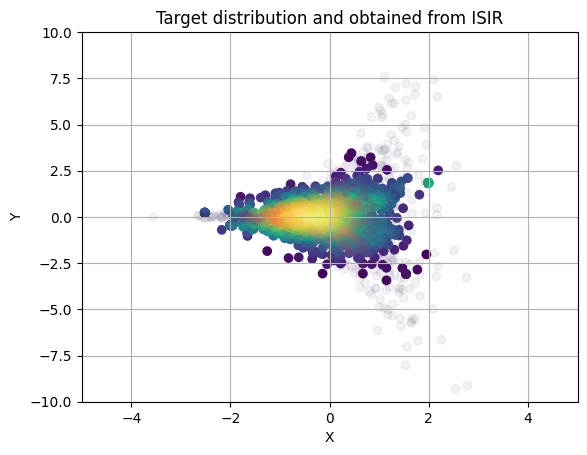

In [48]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from ISIR')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)
ax.set_ylim(-10, 10)
plt.show()

In [49]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.151, Std: 0.003. 
ESS: 0.146 
EMD: 48.333


## dim=50

In [56]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 50

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [57]:
target =  Funnel(num_dims=dim)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [58]:
z_0 = proposal.sample((N_CHAINS, ))
chains, acc_rate  = ISIR(
                  z_0,
                  target,
                  proposal,
                  N_SAMPLES,
                  BURN_IN,
                  n_particles=100,
                  verbose = False,
                )


In [59]:
chains.shape

torch.Size([1000, 1, 50])

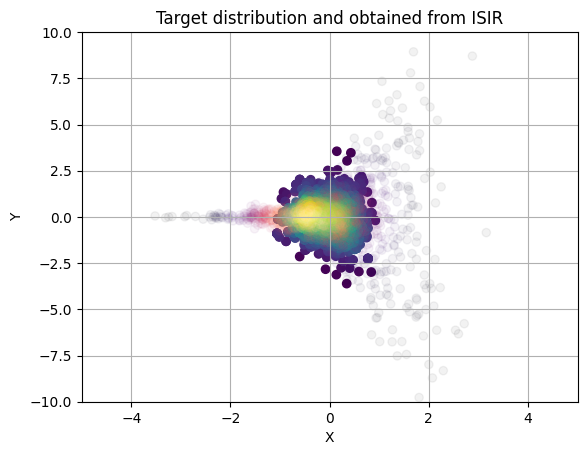

In [60]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from ISIR')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)
ax.set_ylim(-10, 10)
plt.show()

In [61]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.167, Std: 0.003. 
ESS: 0.312 
EMD: 326.931


## dim=100

In [67]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 100

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [68]:
target =  Funnel(num_dims=dim)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [69]:
z_0 = proposal.sample((N_CHAINS, ))
chains, acc_rate  = ISIR(
                  z_0,
                  target,
                  proposal,
                  N_SAMPLES,
                  BURN_IN,
                  n_particles=100,
                  verbose = False,
                )


In [70]:
chains.shape

torch.Size([1000, 1, 100])

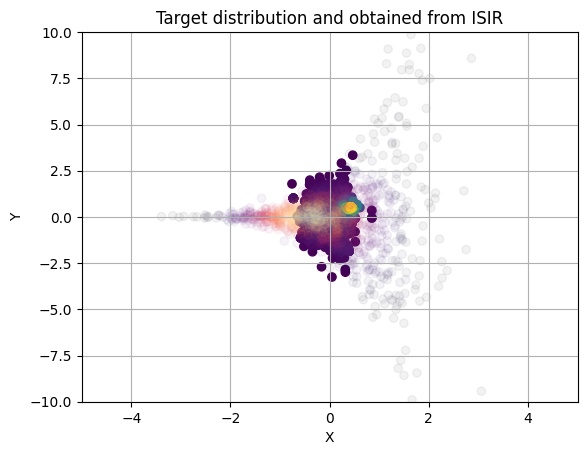

In [71]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from ISIR')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)
ax.set_ylim(-10, 10)
plt.show()

In [72]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.296, Std: 0.003. 
ESS: 0.047 
EMD: 680.163


## HMC w Funnel

## dim=2

In [73]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 2

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [74]:
target =  Funnel(num_dims=dim)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [75]:
z_0 = proposal.sample((N_CHAINS, ))
chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size=0.1,
                  num_leapfrog_steps=10,
                  verbose = False,
                )


Sample: 100%|██████████| 1100/1100 [00:03, 337.72it/s, step size=7.49e-01, acc. prob=0.886]


In [76]:
chains.shape

torch.Size([1000, 1, 2])

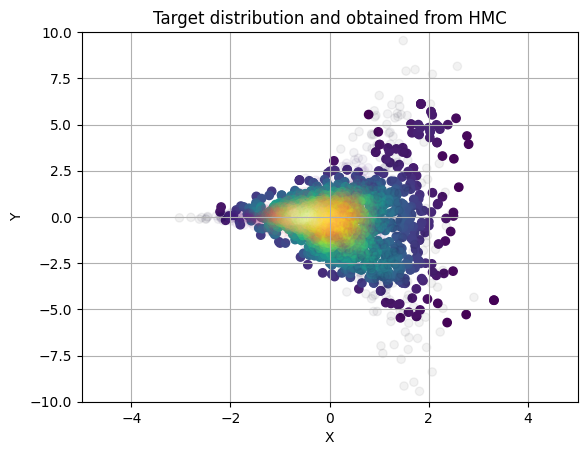

In [77]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from HMC')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)
ax.set_ylim(-10, 10)
plt.show()

In [78]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.133, Std: 0.006. 
ESS: 0.034 
EMD: 2.952


## dim=10

In [79]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 10

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [80]:
target =  Funnel(num_dims=dim)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [81]:
z_0 = proposal.sample((N_CHAINS, ))
chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size=0.1,
                  num_leapfrog_steps=10,
                  verbose = False,
                )


Sample: 100%|██████████| 1100/1100 [00:07, 141.73it/s, step size=4.97e-01, acc. prob=0.884]


In [82]:
chains.shape

torch.Size([1000, 1, 10])

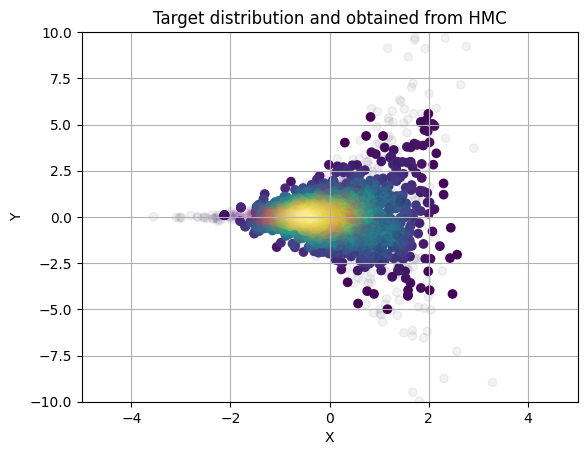

In [83]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from HMC')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)
ax.set_ylim(-10, 10)
plt.show()

In [84]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.107, Std: 0.003. 
ESS: 0.056 
EMD: 47.285


## dim=50

In [91]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 50

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [92]:
target =  Funnel(num_dims=dim)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [93]:
z_0 = proposal.sample((N_CHAINS, ))
chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size=0.1,
                  num_leapfrog_steps=10,
                  verbose = False,
                )


Sample: 100%|██████████| 1100/1100 [00:05, 211.08it/s, step size=2.17e-01, acc. prob=0.887]


In [94]:
chains.shape

torch.Size([1000, 1, 50])

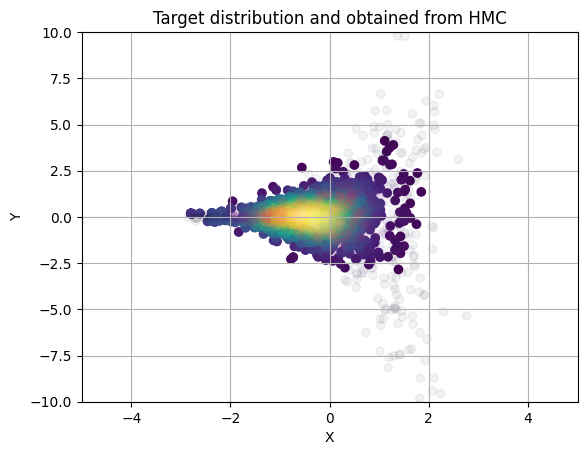

In [95]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from HMC')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)
ax.set_ylim(-10, 10)
plt.show()

In [96]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.178, Std: 0.003. 
ESS: 0.113 
EMD: 313.797


## dim=100

In [103]:
torch.set_default_tensor_type(torch.DoubleTensor)

dim = 100

latent_size = dim
N_CHAINS = torch.tensor(1)
N_SAMPLES = 1000
BURN_IN = 100
device="cpu"

In [104]:
target =  Funnel(num_dims=dim)
proposal = MNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [105]:
z_0 = proposal.sample((N_CHAINS, ))
chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size=0.1,
                  num_leapfrog_steps=10,
                  verbose = False,
                )


Sample: 100%|██████████| 1100/1100 [00:04, 242.22it/s, step size=2.51e-01, acc. prob=0.826]


In [106]:
chains.shape

torch.Size([1000, 1, 100])

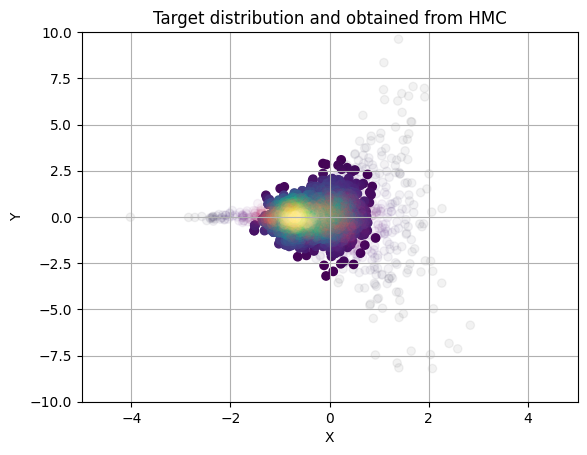

In [107]:
numpy_array = chains.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from HMC')
ax.grid(True)
visualize_dist_(numpy_array, ax)
visualize_dist_nf(target, ax=ax, s=1000, nf = None, alpha=0.05, cmap="magma")
ax.set_xlim(-5, 5)
ax.set_ylim(-10, 10)
plt.show()

In [108]:
true_chain = target.sample(1000)
N_SAMPLES_METRICS = 1000

metrics = compute_metrics(
                      true_chain.numpy(),
                      chains.numpy(),
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.190, Std: 0.004. 
ESS: 0.191 
EMD: 721.810
